In [1]:
import sys
import os
sys.path.append(os.path.abspath('../../'))

from rcgp.morcgp import MOGPRegressor, MORCGPRegressor
from rcgp.kernels import ConstantMean, RBFKernel, SineMean
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams.update({
    "text.usetex": True,         
    "font.family": "serif",       
    "text.latex.preamble": r"\usepackage{amsmath}",
    'font.size': 24,         
    'axes.labelsize': 24,    
    'xtick.labelsize': 24,   
    'ytick.labelsize': 24,  
    'legend.fontsize': 20,
    'lines.linewidth': 4,    
    'lines.markersize': 5   
})

In [2]:
df = pd.read_csv('cisplatin.csv')
df

,Unnamed: 0,drug,cell_line,log10_dose,viability
0,1,CISPLATIN,924238,-2.397711,0.972837
1,2,CISPLATIN,924238,-2.221620,1.000000
2,3,CISPLATIN,924238,-1.897749,0.947334
3,4,CISPLATIN,924238,-1.721658,1.000000
4,5,CISPLATIN,924238,-1.408240,0.931629
...,...,...,...,...,...
19509,19510,CISPLATIN,908441,-0.221772,0.923064
19510,19511,CISPLATIN,908441,0.102098,1.000000
19511,19512,CISPLATIN,908441,0.278189,0.622700
19512,19513,CISPLATIN,908441,0.602060,0.847234


In [3]:
def preprocess_data(df, cell_line_indices):
    df_copy = df[['cell_line', 'log10_dose', 'viability']]
    
    unique_cell_lines = df_copy['cell_line'].unique()
    selected_cell_lines = unique_cell_lines[cell_line_indices]  # Select by indices
    
    df_subset = df_copy[df_copy['cell_line'].isin(selected_cell_lines)]
    
    pivoted = df_subset.pivot(index='cell_line', columns='log10_dose', values='viability')
    
    Y = pivoted.to_numpy()
    x = pivoted.columns.to_numpy().reshape(-1, 1)
    
    return x, Y.T

list_cell_lines = [3, 13, 15, 29, 0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12]
# list_cell_lines = [3, 13, 15, 29]
x, Y = preprocess_data(df, list_cell_lines)

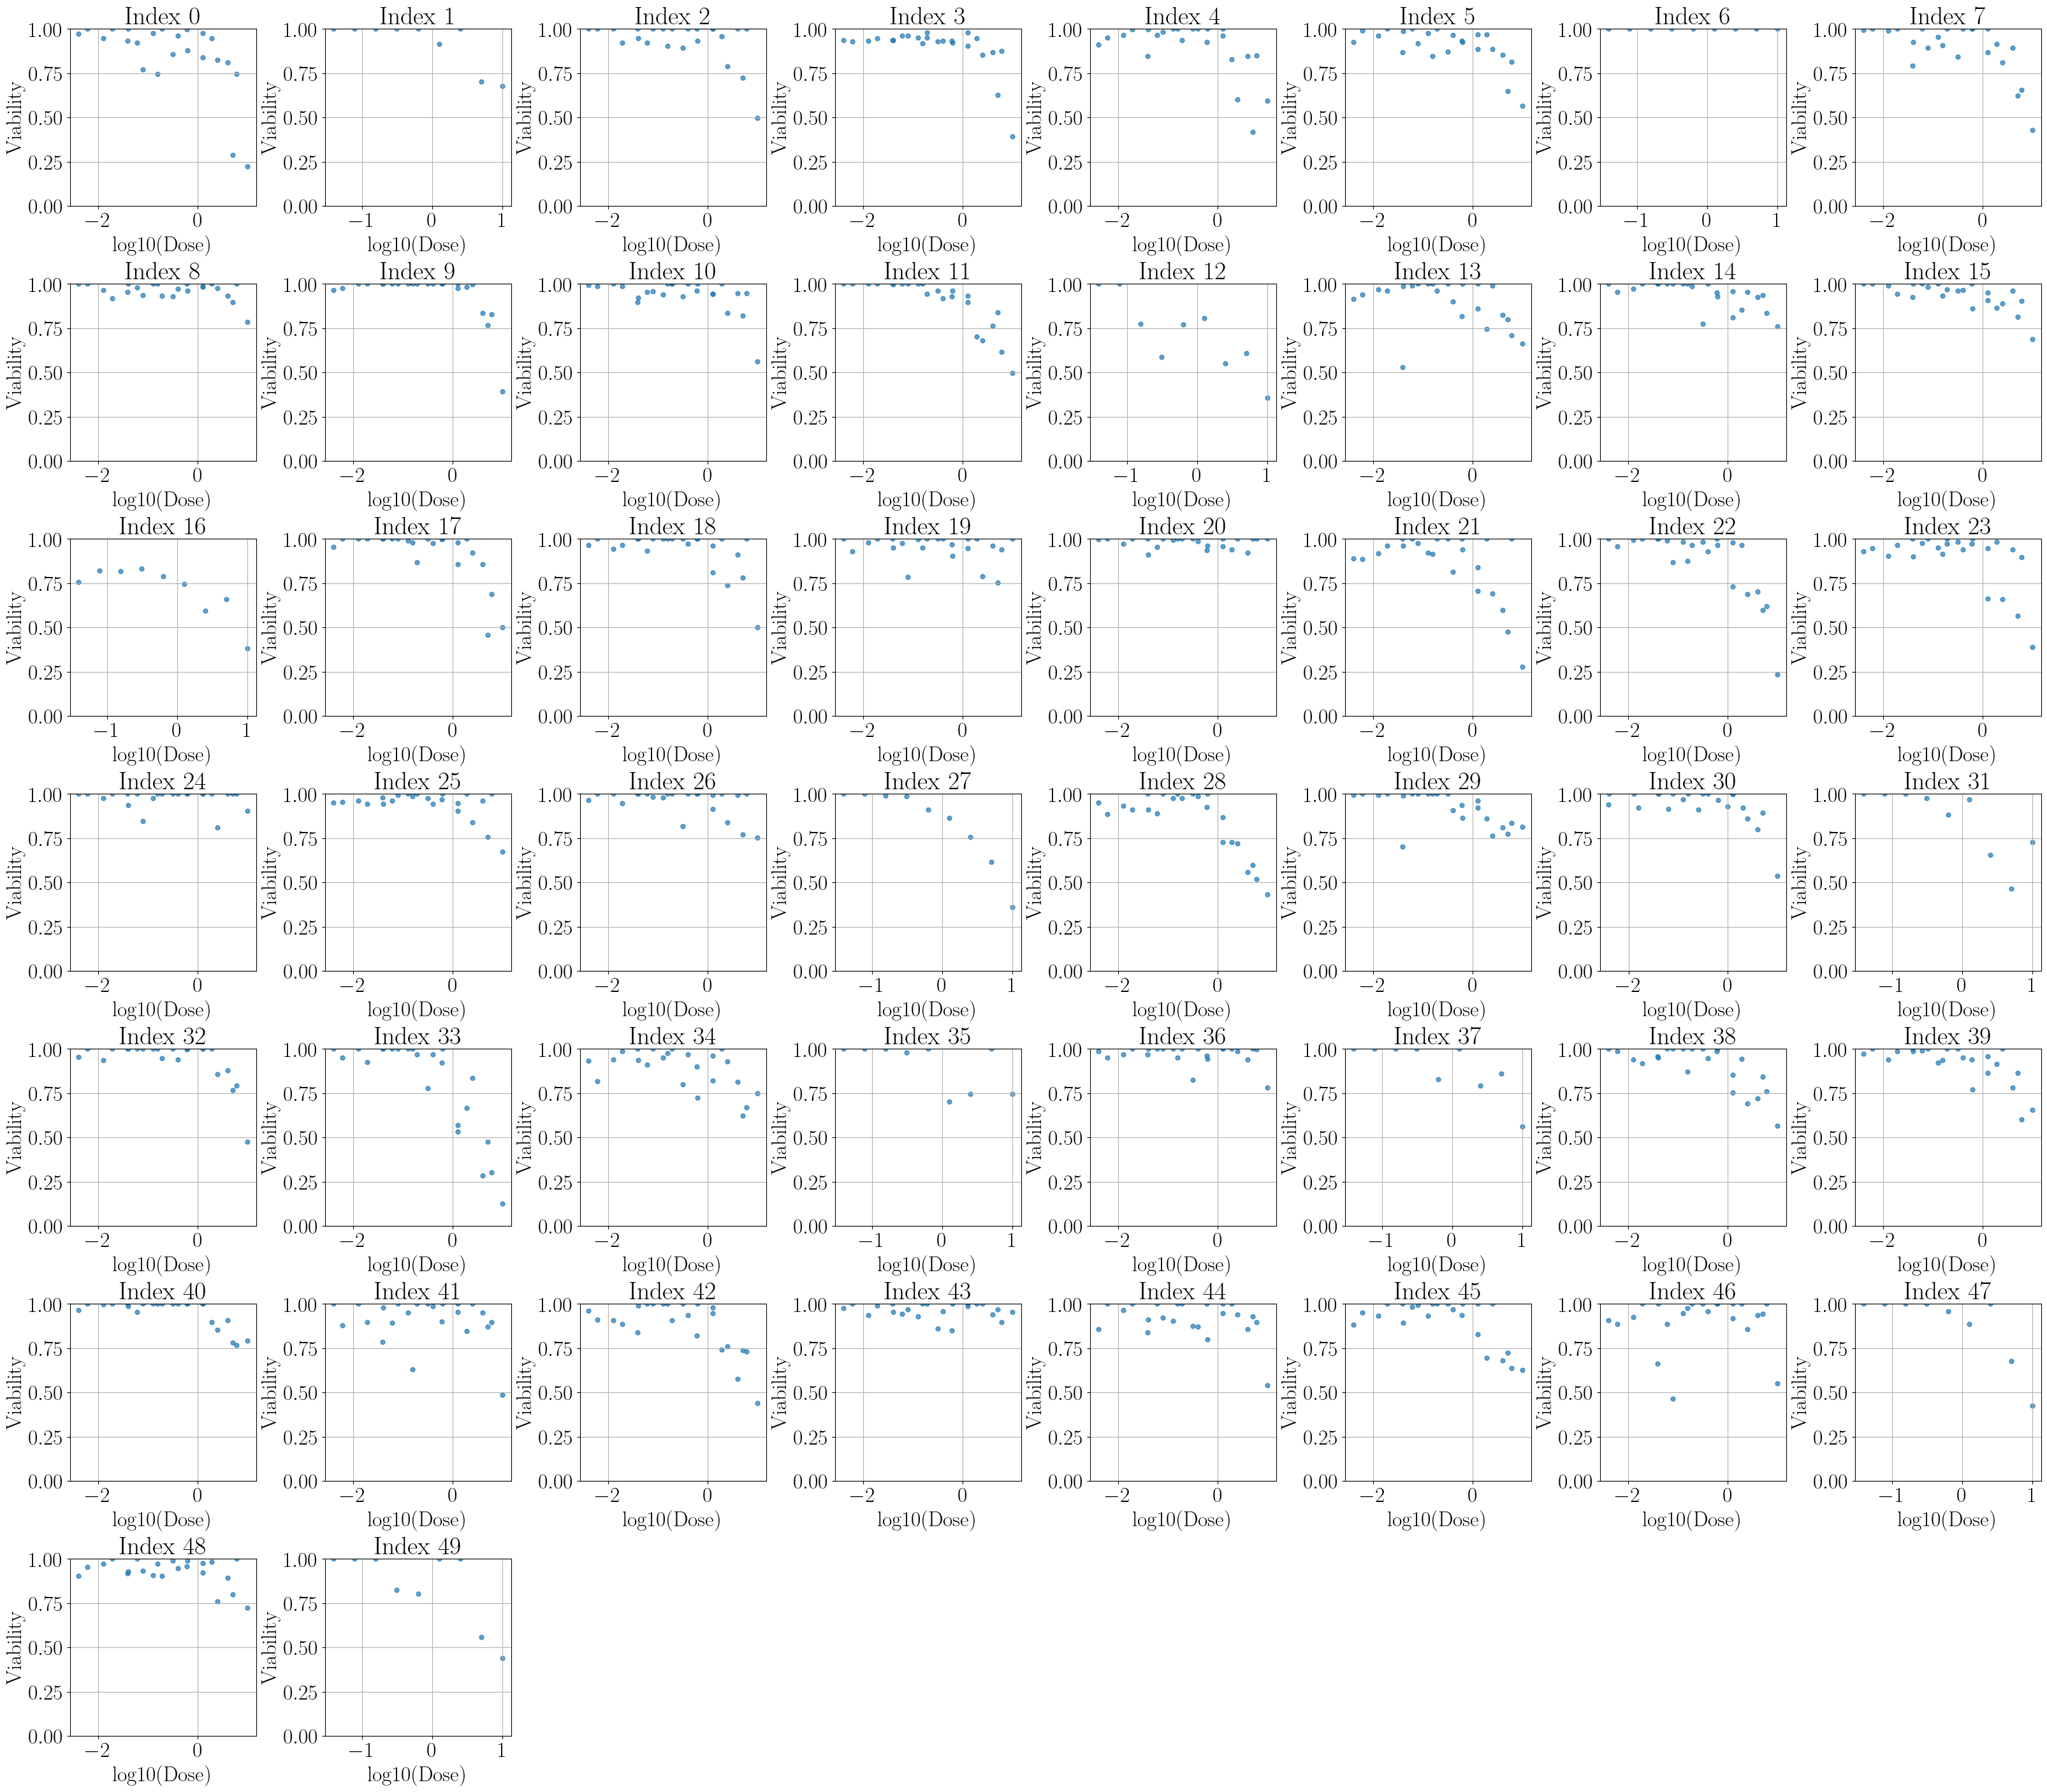

In [10]:
def visual_examples(df, k):
    unique_cell_lines = df['cell_line'].unique()
    k = min(k, len(unique_cell_lines))  # avoid indexing error

    # Calculate number of rows and columns for the grid
    cols = int(np.ceil(np.sqrt(k)))
    rows = int(np.ceil(k / cols))

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4), constrained_layout=True)

    # Flatten axes for easy indexing
    axes = axes.flatten()

    for i in range(k):
        cell_line = unique_cell_lines[i]
        df_n = df[df['cell_line'] == cell_line]

        ax = axes[i]
        ax.scatter(df_n['log10_dose'], df_n['viability'], alpha=0.7)
        ax.set_title(f'Index {i}')
        ax.set_xlabel('log10(Dose)')
        ax.set_ylabel('Viability')
        ax.grid(True)

        ax.set_ylim(0, 1)

    # Hide any unused subplots
    for j in range(k, len(axes)):
        fig.delaxes(axes[j])

    plt.show()

visual_examples(df, 50)

In [4]:
def generate_A(d, r=1, base_strength=1.0, noise_level=0.1, seed=None):
    if seed is not None:
        np.random.seed(seed)
    # Shared signal: induces positive correlations
    shared_component = base_strength * np.ones((d, r))
    # Small random noise to avoid exact collinearity
    noise = noise_level * np.random.randn(d, r)
    A = shared_component + noise
    return A

## MOGP

Optimized length_scale: 1.9325, noise: 0.004898
Optimized A: [[ 0.16850036 -0.03896239 -0.2443011  -0.23790284 -0.2656723 ]
 [ 0.52575291  0.42431983  0.54659237  0.49357721  0.39765536]
 [ 0.79419225  1.06881328  1.07915655  1.11756217  1.16410321]
 [ 0.4157535   0.44775942  0.31661319  0.36048092  0.34333742]
 [ 0.70240189  0.78274478  0.88769665  0.8633879   0.84308547]
 [ 0.8537744   0.63057562  1.13756641  0.776592    1.08068958]
 [ 0.41270927  0.47013661  0.18352683  0.24268263  0.34597512]
 [ 1.09937869  1.57761953  1.69175433  1.70774311  1.87397166]
 [ 0.38337516  0.02379597  0.22275622  0.08804027 -0.0548442 ]
 [ 0.88283972  1.18220369  1.24424489  1.25831386  1.34129913]
 [ 0.45682032  0.36636579  0.367587    0.33561455  0.30553732]
 [ 0.43929313  0.47728568  0.26034352  0.3229109   0.33336927]
 [ 0.28566144  0.36563276 -0.05204008  0.0764431   0.13091616]
 [ 0.66964575  0.78668823  0.82271174  0.81675551  0.84156892]
 [ 0.92180296  1.25814162  1.27887113  1.32869444  1.3749

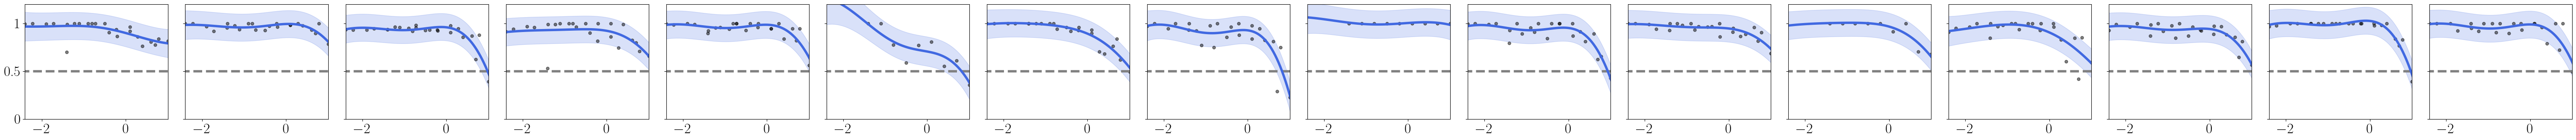

In [5]:
# Initialization
n_outputs = len(list_cell_lines)
prior_mean = 0.5
init_length_scale = 0.2
init_noise_var = 0.1
init_A = generate_A(d=n_outputs, r=5, noise_level=0.1, seed=42)
# print("A:\n", init_A)
# print("B:\n", init_A @ init_A.T)

# Instantiate and train
mogp = MOGPRegressor(n_outputs = n_outputs, mean = prior_mean, length_scale=init_length_scale, noise = init_noise_var, A=init_A)
mogp.fit(x, Y)
# Optimize hyperparameters
mogp.optimize_hyperparameters()

# Predict on test points
x_test = np.linspace(-2.5, 1.5, 100).reshape(-1, 1)
mu, var = mogp.predict(x_test)
std = np.sqrt(var + mogp.noise)

optim_A = mogp.A

# Plotting
fig, axs = plt.subplots(1, n_outputs, figsize=(4 * n_outputs, 4))  # Dynamically adjust figure size

for i in range(n_outputs):
    axs[i].plot(x.flatten(), Y[:, i], 'o', color='black', alpha=0.5)
    axs[i].plot(x_test, prior_mean * np.ones((len(x_test), 1)), '--', color='grey')
    axs[i].plot(x_test.flatten(), mu[:, i], '-', color='royalblue', label='Predicted Mean')
    axs[i].fill_between(x_test.flatten(), mu[:, i] - 2*std[:, i], mu[:, i] + 2*std[:, i], 
                        color='royalblue', alpha=0.2, label='±2 Std. Dev.')

    axs[i].set_ylim([0, 1.2])
    axs[i].set_xlim([x[0], x[-1]])
    axs[i].set_yticks([0, 0.5, 1])

    if i == 0:
        axs[i].set_yticklabels(['0', '0.5', '1'])  # Only show labels on the leftmost plot
    else:
        axs[i].set_yticklabels([])  # Hide on all others

# # Common axis labels
# fig.text(0.5, 0.04, 'log cisplatin dose', ha='center', fontsize=24)
# fig.text(0.04, 0.5, 'Viability', va='center', rotation='vertical', fontsize=24)

plt.tight_layout(rect=[0.05, 0.05, 1, 1])  # Leave room for the labels
plt.show()

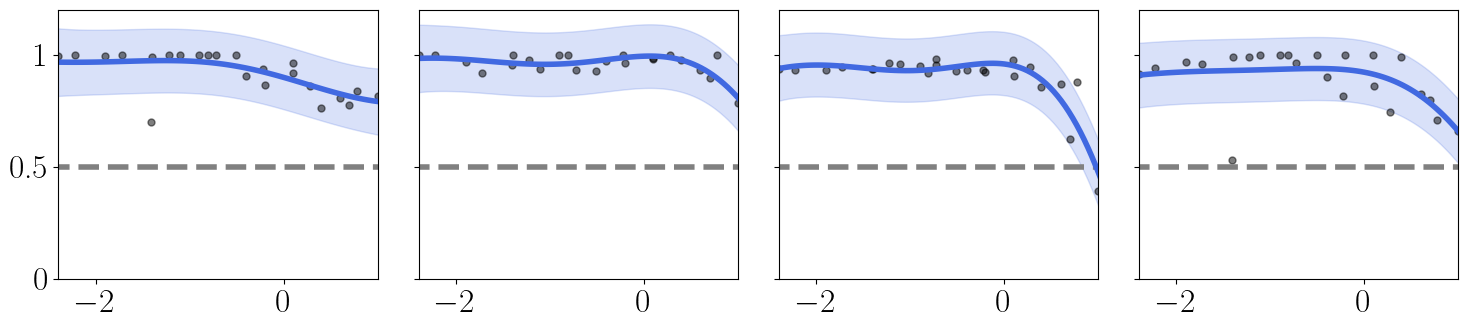

In [6]:
# Plotting
fig, axs = plt.subplots(1, 4, figsize=(16, 4))  # Dynamically adjust figure size

for i in range(4):
    axs[i].plot(x.flatten(), Y[:, i], 'o', color='black', alpha=0.5)
    axs[i].plot(x_test, prior_mean * np.ones((len(x_test), 1)), '--', color='grey')
    axs[i].plot(x_test.flatten(), mu[:, i], '-', color='royalblue', label='Predicted Mean')
    axs[i].fill_between(x_test.flatten(), mu[:, i] - 2*std[:, i], mu[:, i] + 2*std[:, i], 
                        color='royalblue', alpha=0.2, label='±2 Std. Dev.')

    axs[i].set_ylim([0, 1.2])
    axs[i].set_xlim([x[0], x[-1]])
    axs[i].set_yticks([0, 0.5, 1])

    if i == 0:
        axs[i].set_yticklabels(['0', '0.5', '1'])  # Only show labels on the leftmost plot
    else:
        axs[i].set_yticklabels([])  # Hide on all others

# # Common axis labels
# fig.text(0.5, 0.04, 'log cisplatin dose', ha='center', fontsize=24)
# fig.text(0.04, 0.5, 'Viability', va='center', rotation='vertical', fontsize=24)

plt.tight_layout(rect=[0.05, 0.05, 1, 1])  # Leave room for the labels
plt.show()

## MORCGP

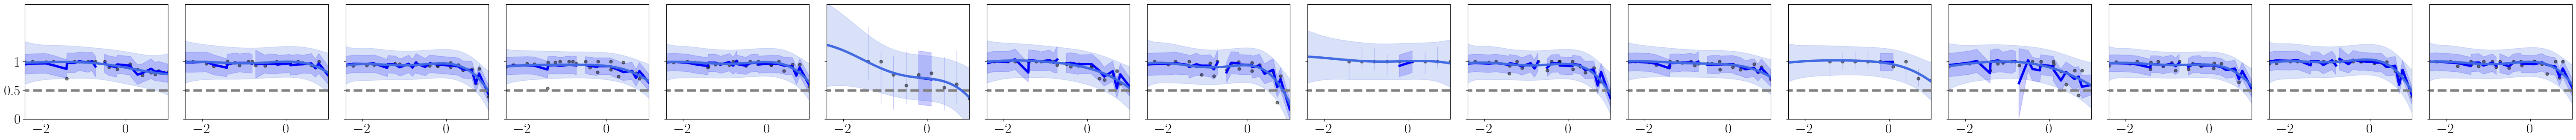

In [7]:
# Initialization
n_outputs = len(list_cell_lines)
prior_mean = 0.5
init_length_scale = 1.9325
init_noise_var = 0.004898
init_A = np.array([
    [0.19999236, 0.18617754, 0.19758124, 0.19932977],
    [0.19201191, 0.17874885, 0.18969746, 0.19137673],
    [0.18925192, 0.17617919, 0.18697063, 0.18862537],
    [0.20740665, 0.19307958, 0.20490645, 0.20671954]
])

# Instantiate and train
morcgp = MORCGPRegressor(n_outputs = n_outputs, mean = prior_mean, length_scale=init_length_scale, noise = init_noise_var, A=optim_A)
predictive_means, predictive_variances = morcgp.fit(x, Y)

# Optimize hyperparameters
# morcgp.optimize_hyperparameters()

# Predict on test points
x_test = np.linspace(-2.5, 1.5, 100).reshape(-1, 1)
mu, var = morcgp.predict(x_test)
std = np.sqrt(var + morcgp.noise)

# Plotting
fig, axs = plt.subplots(1, n_outputs, figsize=(4 * n_outputs, 4))  # Dynamically adjust figure size

for i in range(n_outputs):
    axs[i].plot(x.flatten(), Y[:, i], 'o', color='black', alpha=0.5)

    axs[i].plot(x.flatten(), predictive_means[:, i], '-', color='blue', label=f'Predictive Mean')
    axs[i].fill_between(x.flatten(), predictive_means[:, i] - 2*np.sqrt(predictive_variances)[:, i], predictive_means[:, i] + 2*np.sqrt(predictive_variances)[:, i], color='blue', alpha=0.2, label=f'±2 Std. Dev.')

    axs[i].plot(x_test, prior_mean * np.ones((len(x_test), 1)), '--', color='grey')
    axs[i].plot(x_test.flatten(), mu[:, i], '-', color='royalblue', label='Predicted Mean')
    axs[i].fill_between(x_test.flatten(), mu[:, i] - 2*std[:, i], mu[:, i] + 2*std[:, i], 
                        color='royalblue', alpha=0.2, label='±2 Std. Dev.')

    axs[i].set_ylim([0, 2])
    axs[i].set_xlim([x[0], x[-1]])
    axs[i].set_yticks([0, 0.5, 1])

    if i == 0:
        axs[i].set_yticklabels(['0', '0.5', '1'])  # Only show labels on the leftmost plot
    else:
        axs[i].set_yticklabels([])  # Hide on all others

# # Common axis labels
# fig.text(0.5, 0.04, 'log cisplatin dose', ha='center', fontsize=24)
# fig.text(0.04, 0.5, 'Viability', va='center', rotation='vertical', fontsize=24)

plt.tight_layout(rect=[0.05, 0.05, 1, 1])  # Leave room for the labels
plt.show()

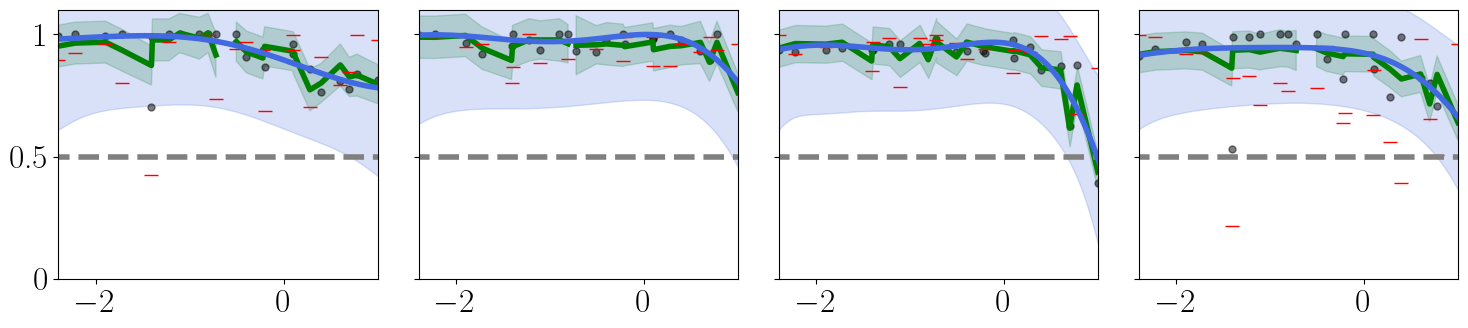

In [17]:
# Plotting
fig, axs = plt.subplots(1, 4, figsize=(4 * 4, 4))  # Dynamically adjust figure size

for i in range(4):
    axs[i].plot(x.flatten(), Y[:, i], 'o', color='black', alpha=0.5)

    axs[i].plot(x.flatten(), predictive_means[:, i], '-', color='green', label=f'Predictive Mean')
    axs[i].fill_between(x.flatten(), predictive_means[:, i] - np.sqrt(predictive_variances)[:, i], predictive_means[:, i] + np.sqrt(predictive_variances)[:, i], color='green', alpha=0.2, label=f'±2 Std. Dev.')

    axs[i].plot(x.flatten(), ((morcgp.w.reshape(n_outputs,-1).T/(morcgp.noise/2)**0.5))[:,i], '_', color='red', label=f'Predictive Mean', markersize=10)

    axs[i].plot(x_test, prior_mean * np.ones((len(x_test), 1)), '--', color='grey')
    axs[i].plot(x_test.flatten(), mu[:, i], '-', color='royalblue', label='Predicted Mean')
    axs[i].fill_between(x_test.flatten(), mu[:, i] - 2*std[:, i], mu[:, i] + 2*std[:, i], 
                        color='royalblue', alpha=0.2, label='±2 Std. Dev.')

    axs[i].set_ylim([0.9, 1.1])
    axs[i].set_xlim([x[0], x[-1]])
    axs[i].set_yticks([0, 0.5, 1])

    if i == 0:
        axs[i].set_yticklabels(['0', '0.5', '1'])  # Only show labels on the leftmost plot
    else:
        axs[i].set_yticklabels([])  # Hide on all others

# # Common axis labels
# fig.text(0.5, 0.04, 'log cisplatin dose', ha='center', fontsize=24)
# fig.text(0.04, 0.5, 'Viability', va='center', rotation='vertical', fontsize=24)

plt.tight_layout(rect=[0.05, 0.05, 1, 1])  # Leave room for the labels
plt.show()